In [6]:
import numpy as np
import pandas as pd

from src.constant import DATA_DIR, DATABASE_DIR, MAIN_DIR
from src.database import DB
from src.database.queries import *
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_from_index_file
from src.solver.TSP_LKH_Solver import TSP_LKH_Solver
from src.aac.SurrogateEstimator import Estimator1

import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

### feature importance

In [4]:
db_path = list(DATABASE_DIR.glob(f"run-plain-30-*.db"))[0]
db = DB(db_path)

query = f"""
    select 
        {db.SCHEMA.EVALUATIONS}.cost,
        {db.SCHEMA.SOLVERS}.*,
        {db.SCHEMA.INSTANCES}.*
    from {db.SCHEMA.EVALUATIONS}
    join {db.SCHEMA.INSTANCES} on {db.SCHEMA.EVALUATIONS}.instance_id = {db.SCHEMA.INSTANCES}.id
    join {db.SCHEMA.SOLVERS} on {db.SCHEMA.EVALUATIONS}.solver_id = {db.SCHEMA.SOLVERS}.id
    """
df = db.query2df(query)
df = df.drop(columns=["id", "filepath", "optimum"])
df = df.dropna()
y = df["cost"]
X = df.drop(columns="cost")
COLUMNS = X.columns

In [36]:
prefix = "run-plain-30"

fi_regressor_size_list = []
fi_classifier_size_list = []

for size in [200, 400, 600]:

    feature_importance_regressor = []
    feature_importance_classifier = []

    for db_path in (MAIN_DIR / "_archive" / "experiments" / "2025-01-27" / str(size) / "database").glob(f"{prefix}-*.db"):
        db = DB(db_path)

        X, y = get_model_training_data(db)
        estimator = Estimator1(
            max_cost=TSP_LKH_Solver.MAX_COST, estimator_pct=0.5
        )
        estimator.fit(X, y)

        s = pd.Series(dict(zip(COLUMNS, estimator.classifier.feature_importances_)))
        feature_importance_classifier.append(s)

        s = pd.Series(dict(zip(COLUMNS, estimator.regressor.feature_importances_)))
        feature_importance_regressor.append(s)

    s = pd.concat(feature_importance_classifier, axis=1).mean(axis=1).to_frame("fi").assign(size=size)
    fi_classifier_size_list.append(s)

    s = pd.concat(feature_importance_regressor, axis=1).mean(axis=1).to_frame("fi").assign(size=size)
    fi_regressor_size_list.append(s)

In [37]:
fi_classifier = pd.concat(fi_classifier_size_list, axis=0)
fi_regressor = pd.concat(fi_regressor_size_list, axis=0)

fi_classifier

,fi,size
ASCENT_CANDIDATES,0.017718,200
BACKBONE_TRIALS,0.006219,200
BACKTRACKING,0.097985,200
CANDIDATE_SET_TYPE,0.006865,200
EXTRA_CANDIDATES,0.040713,200
...,...,...
nnds_mean,0.003169,600
nnds_max,0.000857,600
nnds_sd,0.000783,600
nnds_span,0.000516,600


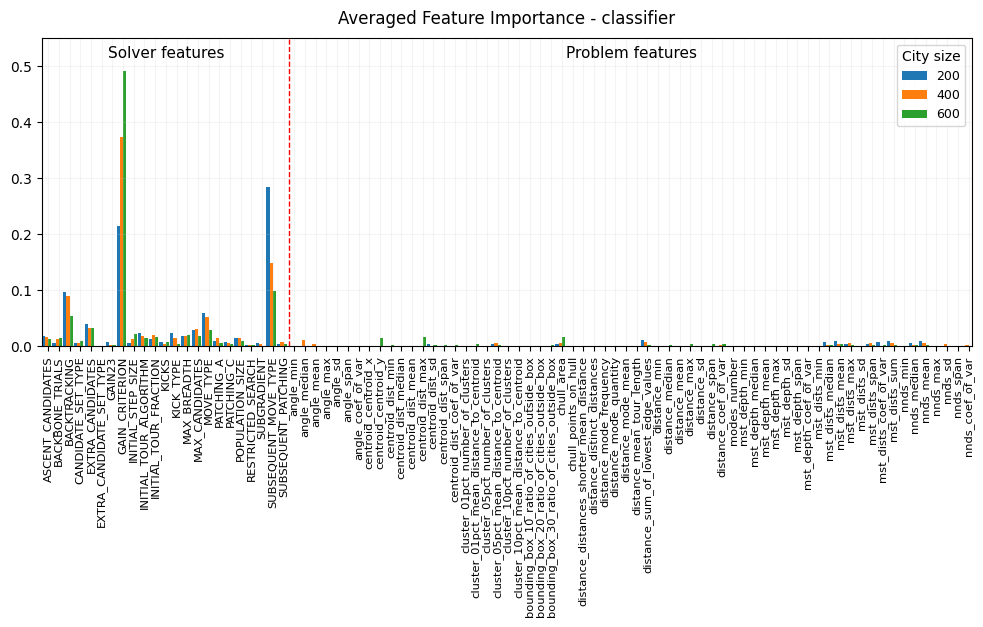

In [104]:
fig, ax = plt.subplots(figsize=(12, 4))

subset = fi_classifier[fi_classifier['size'] == 200]
ax.bar(x=np.arange(0, subset.shape[0], 1), height=subset['fi'], width=0.3, label=f'200')
subset = fi_classifier[fi_classifier['size'] == 400]
ax.bar(x=np.arange(0.3, subset.shape[0] + 0.3, 1), height=subset['fi'], width=0.3, label=f'400')
subset = fi_classifier[fi_classifier['size'] == 600]
ax.bar(x=np.arange(0.6, subset.shape[0] + 0.6, 1), height=subset['fi'], width=0.3, label=f'600')

ax.set_xticks(ticks=np.arange(0.45, subset.shape[0] + 0.45, 1), labels=COLUMNS, rotation=90, fontsize=8.25)
plt.axvline(x=23, c="red", lw=1, ls="--")
plt.title("Averaged Feature Importance - classifier", size=12, y=1.02)
plt.legend(title="City size", fontsize=9)
plt.text(11.5, y=0.51, s="Solver features", fontsize=11, ha="center", va="bottom")
plt.text(55, y=0.51, s="Problem features", fontsize=11, ha="center", va="bottom")
plt.ylim(0, 0.55)
plt.savefig("feature_importance_classifier.png", dpi=300, bbox_inches="tight")
plt.show()

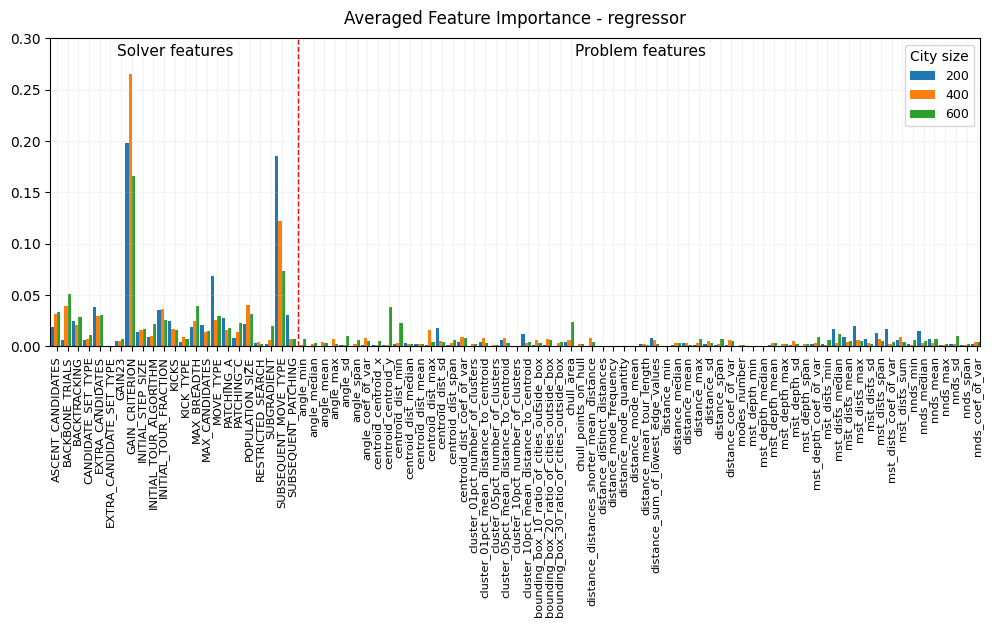

In [108]:
fig, ax = plt.subplots(figsize=(12, 4))

subset = fi_regressor[fi_regressor['size'] == 200]
ax.bar(x=np.arange(0, subset.shape[0], 1), height=subset['fi'], width=0.3, label=f'200')
subset = fi_regressor[fi_regressor['size'] == 400]
ax.bar(x=np.arange(0.3, subset.shape[0] + 0.3, 1), height=subset['fi'], width=0.3, label=f'400')
subset = fi_regressor[fi_regressor['size'] == 600]
ax.bar(x=np.arange(0.6, subset.shape[0] + 0.6, 1), height=subset['fi'], width=0.3, label=f'600')

ax.set_xticks(ticks=np.arange(0.45, subset.shape[0] + 0.45, 1), labels=COLUMNS, rotation=90, fontsize=8.25)
plt.axvline(x=23, c="red", lw=1, ls="--")
plt.title("Averaged Feature Importance - regressor", size=12, y=1.02)
plt.legend(title="City size", fontsize=9)
plt.text(11.5, y=0.28, s="Solver features", fontsize=11, ha="center", va="bottom")
plt.text(55, y=0.28, s="Problem features", fontsize=11, ha="center", va="bottom")
plt.ylim(0, 0.30)
plt.savefig("feature_importance_regressor.png", dpi=300, bbox_inches="tight")
plt.show()

### large test set

In [ ]:
X_list = []
y_list = []

for prefix in ["run-plain-30", "run-plain-250", "run-plain-500"]:
    for db_path in DATABASE_DIR.glob(f"{prefix}-*.db"):
        db = DB(db_path)
        X, y = get_model_training_data(db)
        X_list.append(X)
        y_list.append(y)
    
X_test = np.concatenate(X_list, axis=0)
y_test = np.concatenate(y_list, axis=0)

In [44]:
prefix = "run-plain-500"

acc_list = []
rmse_list = []
training_data_shape_list = []
non_timeout_training_data_shape_list = []
for db_path in DATABASE_DIR.glob(f"{prefix}-*.db"):
    db = DB(db_path)

    X, y = get_model_training_data(db)
    estimator = Estimator1(
        max_cost=TSP_LKH_Solver.MAX_COST, estimator_pct=0.5
    )
    estimator.fit(X, y)
    acc_, rmse = estimator.score(X_test, y_test)
    training_data_shape = X.shape[0]
    non_timeout_training_data_shape = X[estimator._mask_non_timeout].shape[0]
    acc_list.append(acc_)
    rmse_list.append(rmse)
    training_data_shape_list.append(training_data_shape)
    non_timeout_training_data_shape_list.append(non_timeout_training_data_shape)

acc = np.mean(acc_list)
rmse = np.mean(rmse_list)
training_data_shape = np.mean(training_data_shape_list)
non_timeout_training_data_shape = np.mean(non_timeout_training_data_shape_list)

print(f"{acc=:.4f}, {rmse=:.4f}, {training_data_shape=:.1f}, {non_timeout_training_data_shape=:.1f}")

acc=0.7990, rmse=2.0140, training_data_shape=75000.0, non_timeout_training_data_shape=39751.0
